# MODELE DE CHATBOT

Modèle de chatbot simple ne s'appuyant que sur des couches entièrement connectées afin d'être éxécutable sur la STM32

Réalisé par Elisa Delhommé

Source: https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758
| https://moncoachdata.com/blog/construire-un-chatbot-en-python/

Les versions suivantes sont nécessaires pour être compatibles avec la version de CubeAI utilisée ultérieurement (v 5.1.2).

In [ ]:
!pip install q tensorflow==2.0.0
!pip install q keras==2.3.1

L'absence de couches d'Embedding (non supportée par la version de CubeAI employée, ce qui empêche par ailleurs l'utilisation de couches récurrentes telles que les LSTM ou RNN) nous mène à créer un dictionnaire afin de prédire la réponse au message porté par l'utilisateur.

La création d'un dictionnaire a également l'avantage d'avoir la possibilité de l'enrichir avec l'application recherchée et ainsi d'obtenir des réponses davantages ciblées.

Ici, on peut par exemple prévoir le cas où l'utilisateur demanderait l'emplacement de la machine à café par exemple.

In [ ]:
# utilisation d'un dictionnaire pour représenter un fichier JSON d'intentions
data = {"intents": [
             {"tag": "greeting",
              "patterns": ["Hello", "La forme?", "yo", "Salut", "ça roule?"],
              "responses": ["Salut à toi!", "Hello", "Comment vas tu?", "Salutations!", "Enchanté"],
             },
             {"tag": "age",
              "patterns": ["Quel âge as-tu?", "C'est quand ton anniversaire?", "Quand es-tu né?"],
              "responses": ["J'ai 25 ans", "Je suis né en 1996", "Ma date d'anniversaire est le 3 juillet et je suis né en 1996", "03/07/1996"]
             },
             {"tag": "date",
              "patterns": ["Que fais-tu ce week-end?",
"Tu veux qu'on fasse un truc ensemble?", "Quels sont tes plans pour cette semaine"],
              "responses": ["Je suis libre toute la semaine", "Je n'ai rien de prévu", "Je ne suis pas occupé"]
             },
             {"tag": "name",
              "patterns": ["Quel est ton prénom?", "Comment tu t'appelles?", "Qui es-tu?"],
              "responses": ["Mon prénom est Miki", "Je suis Miki", "Miki"]
             },
             {"tag": "goodbye",
              "patterns": [ "bye", "Salut", "see ya", "adios", "cya"],
              "responses": ["C'était sympa de te parler", "à plus tard", "On se reparle très vite!"]
             },
             {"tag": "object_location",
              "patterns": [ "Where is the coffee maker?", "Où est la cafetière?"],
              "responses": ["On the kitchen table","Sur la table de la cuisine"]
             }
]}

In [ ]:
data

{'intents': [{'patterns': ['Hello', 'La forme?', 'yo', 'Salut', 'ça roule?'],
   'responses': ['Salut à toi!',
    'Hello',
    'Comment vas tu?',
    'Salutations!',
    'Enchanté'],
   'tag': 'greeting'},
  {'patterns': ['Quel âge as-tu?',
    "C'est quand ton anniversaire?",
    'Quand es-tu né?'],
   'responses': ["J'ai 25 ans",
    'Je suis né en 1996',
    "Ma date d'anniversaire est le 3 juillet et je suis né en 1996",
    '03/07/1996'],
   'tag': 'age'},
  {'patterns': ['Que fais-tu ce week-end?',
    "Tu veux qu'on fasse un truc ensemble?",
    'Quels sont tes plans pour cette semaine'],
   'responses': ['Je suis libre toute la semaine',
    "Je n'ai rien de prévu",
    'Je ne suis pas occupé'],
   'tag': 'date'},
  {'patterns': ['Quel est ton prénom?',
    "Comment tu t'appelles?",
    'Qui es-tu?'],
   'responses': ['Mon prénom est Miki', 'Je suis Miki', 'Miki'],
   'tag': 'name'},
  {'patterns': ['bye', 'Salut', 'see ya', 'adios', 'cya'],
   'responses': ["C'était sympa de 

In [ ]:
import json
import string
import random 
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer 
import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout, LSTM, Flatten
nltk.download("wordnet")
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Préparation des données d'entraînement

In [ ]:
# initialisation de lemmatizer pour obtenir la racine des mots
lemmatizer = WordNetLemmatizer()
# création des listes
words = []
classes = []
doc_X = []
doc_y = []
# parcourir avec une boucle For toutes les intentions
# tokéniser chaque pattern et ajouter les tokens à la liste words, les patterns et
# le tag associé à l'intention sont ajoutés aux listes correspondantes
for intent in data["intents"]:
    for pattern in intent["patterns"]:
        tokens = nltk.word_tokenize(pattern)
        words.extend(tokens)
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # ajouter le tag aux classes s'il n'est pas déjà là 
    if intent["tag"] not in classes:
        classes.append(intent["tag"])
# lemmatiser tous les mots du vocabulaire et les convertir en minuscule
# si les mots n'apparaissent pas dans la ponctuation
words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in string.punctuation]
# trier le vocabulaire et les classes par ordre alphabétique et prendre le
# set pour s'assurer qu'il n'y a pas de doublons
words = sorted(set(words))
classes = sorted(set(classes))

In [ ]:
print(words)

['adios', 'anniversaire', 'as-tu', 'bye', "c'est", 'cafetière', 'ce', 'cette', 'coffee', 'comment', 'cya', 'ensemble', 'es-tu', 'est', 'fais-tu', 'fasse', 'forme', 'hello', 'is', 'la', 'maker', 'né', 'où', 'plan', 'pour', 'prénom', "qu'on", 'quand', 'que', 'quel', 'quels', 'qui', 'roule', 'salut', 'see', 'semaine', 'sont', "t'appelles", 'te', 'the', 'ton', 'truc', 'tu', 'un', 'veux', 'week-end', 'where', 'ya', 'yo', 'âge', 'ça']


In [ ]:
len(words)

51

In [ ]:
print(classes)

['age', 'date', 'goodbye', 'greeting', 'name', 'object_location']


In [ ]:
print(doc_X)

['Hello', 'La forme?', 'yo', 'Salut', 'ça roule?', 'Quel âge as-tu?', "C'est quand ton anniversaire?", 'Quand es-tu né?', 'Que fais-tu ce week-end?', "Tu veux qu'on fasse un truc ensemble?", 'Quels sont tes plans pour cette semaine', 'Quel est ton prénom?', "Comment tu t'appelles?", 'Qui es-tu?', 'bye', 'Salut', 'see ya', 'adios', 'cya', 'Where is the coffee maker?', 'Où est la cafetière?']


In [ ]:
print(doc_y)

['greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'age', 'age', 'age', 'date', 'date', 'date', 'name', 'name', 'name', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'goodbye', 'object_location', 'object_location']


In [ ]:
# liste pour les données d'entraînement
training = []
out_empty = [0] * len(classes)
# création du modèle d'ensemble de mots
for idx, doc in enumerate(doc_X):
    bow = []
    text = lemmatizer.lemmatize(doc.lower())
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    # marque l'index de la classe à laquelle le pattern atguel est associé à
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1
    # ajoute le one hot encoded BoW et les classes associées à la liste training
    training.append([bow, output_row])
# mélanger les données et les convertir en array
random.shuffle(training)
training = np.array(training, dtype=object)
# séparer les features et les labels target
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

In [ ]:
# définition de quelques paramètres
input_shape = (len(train_X[0]),)
output_shape = len(train_y[0])
epochs = 200

In [ ]:
input_shape, output_shape

((51,), 6)

## Développement du modèle

Le modèle permet la prédiction de la classe à laquelle appartient le message entré par l'utilisateur. A partir de cette classe, il pourra ensuite choisir une réponse adaptée pour renvoyer à l'utilisateur.

In [ ]:
# modèle Deep Learning
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
#model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
#model.add(Dropout(0.3))
model.add(Dense(output_shape, activation = "softmax"))
adam = tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=["accuracy"])

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               6656      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 15,302
Trainable params: 15,302
Non-trainable params: 0
_________________________________________________________________
None


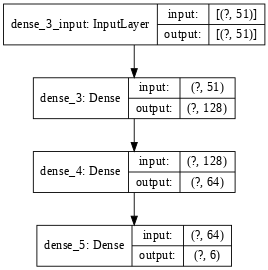

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

## Entraînement du modèle

In [ ]:
epochs = 200

In [ ]:
# entraînement du modèle
history = model.fit(x=train_X, y=train_y, epochs=epochs, verbose=1)

Train on 21 samples
Epoch 1/200
21/21 [==============================] - 0s 601us/sample - loss: 0.0660 - accuracy: 0.9524
Epoch 2/200
21/21 [==============================] - 0s 414us/sample - loss: 0.0660 - accuracy: 0.9524
Epoch 3/200
21/21 [==============================] - 0s 207us/sample - loss: 0.0660 - accuracy: 0.9524
Epoch 4/200
21/21 [==============================] - 0s 249us/sample - loss: 0.0660 - accuracy: 0.9524
Epoch 5/200
21/21 [==============================] - 0s 234us/sample - loss: 0.0660 - accuracy: 0.9524
Epoch 6/200
21/21 [==============================] - 0s 333us/sample - loss: 0.0660 - accuracy: 0.9524
Epoch 7/200
21/21 [==============================] - 0s 371us/sample - loss: 0.0660 - accuracy: 0.9524
Epoch 8/200
21/21 [==============================] - 0s 345us/sample - loss: 0.0660 - accuracy: 0.9524
Epoch 9/200
21/21 [==============================] - 0s 316us/sample - loss: 0.0660 - accuracy: 0.9524
Epoch 10/200
21/21 [==============================] -

### Affichage de l'historique d'entraînement

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

Text(0.5, 1.0, 'Training Loss')

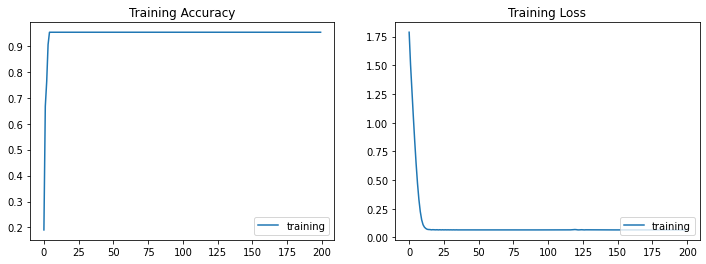

In [ ]:
epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="training")
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="training")
plt.legend(loc='lower right')
plt.title('Training Loss')

## Fonctions d'encodage et décodage du texte

Fonction permettant de séparer une chaîne de caractères en plusieurs sous chaînes pour chacun des mots et ponctuations

<font color="lightgreen">
Exemple:
clean_text("comment ça va?") = ['comment', 'ça', 'va', '?']


In [ ]:
def clean_text(text): 
  tokens = nltk.word_tokenize(text)
  tokens = [lemmatizer.lemmatize(word) for word in tokens]
  return tokens

Fonction permettant l'encodage d'une chaîne de caractère pour traitement par le réseau de neurones
Précisément : met des 1 aux indices où un mot de la liste de référence (liste words) est repéré

<font color="lightgreen">
Exemple:
bag_of_words("comment ça va?", words) = array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                                              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                                               0, 0, 0, 0, 0, 0, 1])
Les mots "comment" et "ça" ont été reconnus dans l'exemple

In [ ]:
def bag_of_words(text, vocab): 
  tokens = clean_text(text)
  bow = [0] * len(vocab)
  for w in tokens: 
    for idx, word in enumerate(vocab):
      if word == w: 
        bow[idx] = 1
  return np.array(bow)

Fonction permettant de prédire la classe (le tag dans le dictionnaire) du message envoyé par l'utilisateur

<font color="lightgreen">
Exemple: pred_class("comment ça va?", words, classes) = ['greeting']

In [ ]:
def pred_class(text, vocab, labels): 
  bow = bag_of_words(text, vocab)
  result = model.predict(np.array([bow]))[0] #renvoi un array de 6 avec 
  thresh = 0.2
  y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh] #choisit le max des probas si supérieur à 0.2
  y_pred.sort(key=lambda x: x[1], reverse=True)
  return_list = []
  for r in y_pred:
    return_list.append(labels[r[0]])
  return return_list

Fonction permettant d'obtenir une réponse au message de l'utilisateur en choisissant de façon aléatoire une réponse qui coîncide dans le dictionnaire.

<font color="lightgreen">
Exemple:
get_response(['greeting'], data) = 'Salutations!'

In [ ]:
def get_response(intents_list, intents_json): 
  tag = intents_list[0]
  list_of_intents = intents_json["intents"]
  for i in list_of_intents: 
    if i["tag"] == tag:
      result = random.choice(i["responses"])
      break
  return result

## Test du chatbot

In [ ]:
# lancement du chatbot
while True:
    message = input("")
    intents = pred_class(message, words, classes)
    result = get_response(intents, data)
    print(result)

In [ ]:
model_file_name = 'chatbot'
model.save(model_file_name + '.h5')